In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential

tfd = tfp.distributions
tfpl = tfp.layers

### Univariate distributions


In [3]:
normal = tfd.Normal(loc=0, scale=1)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [4]:
normal.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.26628157,  0.3328248 , -0.09373247, -1.0304244 , -0.9278153 ,
       -0.528293  ,  0.51225215,  1.0743402 , -1.808754  , -0.04087388],
      dtype=float32)>

In [5]:
normal.prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3989423>

In [6]:
normal.log_prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

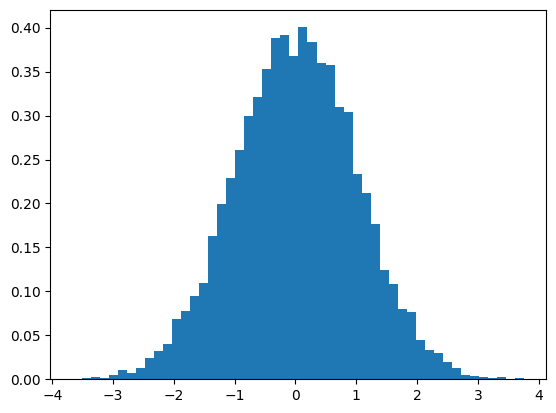

In [7]:
plt.hist(normal.sample(10000), bins=50, density=True)
plt.show()

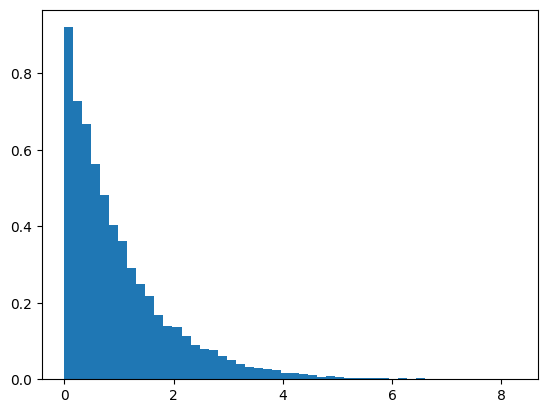

In [8]:
exp = tfd.Exponential(rate=1)
plt.hist(exp.sample(10000), bins=50, density=True)
plt.show()

In [9]:
exp.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.75321925, 1.065525  , 0.12848422, 0.7078147 , 0.21372631,
       1.5351701 , 0.15266566, 0.21918328, 0.35905746, 0.5376988 ],
      dtype=float32)>

In [10]:
bern = tfd.Bernoulli(probs=0.8)
bern.sample(20)

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)>

In [11]:
for k in [0, 0.5, 1, -1]:
    print(f"prob result {bern.prob(k)} for k = {k}")

prob result 0.19999998807907104 for k = 0
prob result 0.3999999761581421 for k = 0.5
prob result 0.800000011920929 for k = 1
prob result 0.04999999701976776 for k = -1


In [12]:
def my_bernoulli(p_success, k):
    return np.power(p_success, k) * np.power((1 - p_success), (1 - k))


for k in [0, 0.5, 1, -1]:
    print(f"prob result {my_bernoulli(0.8, k)} for k = {k}")

prob result 0.19999999999999996 for k = 0
prob result 0.3999999999999999 for k = 0.5
prob result 0.8 for k = 1
prob result 0.049999999999999975 for k = -1


### batching


In [13]:
batch = tfd.Bernoulli(probs=[0.1, 0.25, 0.5, 0.75, 0.9])
batch, batch.sample(5)

(<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[5] event_shape=[] dtype=int32>,
 <tf.Tensor: shape=(5, 5), dtype=int32, numpy=
 array([[1, 0, 0, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 1, 0, 1, 1]], dtype=int32)>)

### Multivariate distributions


In [14]:
mv_normal = tfd.MultivariateNormalDiag(loc=[-1, 0.5], scale_diag=[1.0, 1.5])
mv_normal.sample(3)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.589128  ,  0.38790032],
       [-3.068023  ,  1.5343143 ],
       [-0.47602683,  1.0951669 ]], dtype=float32)>

In [15]:
batched_mv_normal = tfd.MultivariateNormalDiag(
    loc=[[0.3, 0.8, 1.1], [2.3, -0.3, -1.0]],
    scale_diag=[[1.5, 1.0, 0.4], [2.5, 1.5, 0.5]],
)
batched_mv_normal.sample(2), batched_mv_normal.log_prob(2)

(<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
 array([[[ 2.0309734 ,  1.8395572 ,  1.8149159 ],
         [ 0.44466472, -0.3318128 , -1.527174  ]],
 
        [[ 1.6884935 , -0.09738791,  0.94670826],
         [ 1.4814643 ,  2.5695326 , -0.377361  ]]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -6.1394625, -22.568178 ], dtype=float32)>)

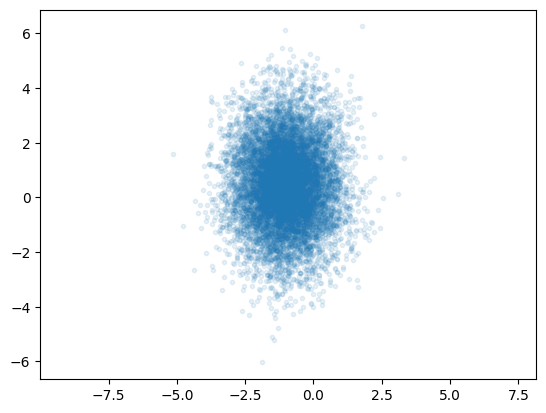

In [16]:
plt_sample = mv_normal.sample(10000)
plt.scatter(plt_sample[:, 0], plt_sample[:, 1], alpha=0.1, marker=".")
plt.axis("equal")
plt.show()

In [17]:
mv_diag_batch = tfd.MultivariateNormalDiag(
    loc=[[0, 0], [0, 0], [0, 0]], scale_diag=[[1, 2], [2, 1], [2, 2]]
)
mv_diag_batch.sample(5)

<tf.Tensor: shape=(5, 3, 2), dtype=float32, numpy=
array([[[ 0.0924846 ,  1.7928302 ],
        [ 1.8392069 , -0.12890096],
        [-0.6343142 ,  1.1688923 ]],

       [[-0.48215818,  1.6001352 ],
        [ 2.3249922 , -0.3324664 ],
        [-1.1792566 ,  1.3495284 ]],

       [[ 1.4724894 , -2.8295841 ],
        [-0.29786786, -0.10444885],
        [-0.01098523, -0.13189557]],

       [[ 1.455159  ,  4.404035  ],
        [ 0.0885912 ,  0.47895268],
        [-1.4524527 , -1.9491014 ]],

       [[ 0.23795795,  2.704455  ],
        [-1.7947631 ,  0.6567202 ],
        [ 0.40096715, -1.3591645 ]]], dtype=float32)>

In [18]:
mv_diag_batch.log_prob(mv_diag_batch.sample(5))

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ -2.707285 ,  -3.5062158,  -4.437216 ],
       [ -2.6089704,  -3.078089 ,  -4.97948  ],
       [ -3.659806 ,  -2.5314984,  -3.5114245],
       [ -3.1247907,  -2.9814594,  -3.328529 ],
       [ -2.6000528, -12.547283 ,  -3.5407524]], dtype=float32)>

In [19]:
plt_sample_batch = mv_diag_batch.sample(10000)
plt_sample_batch.shape

TensorShape([10000, 3, 2])

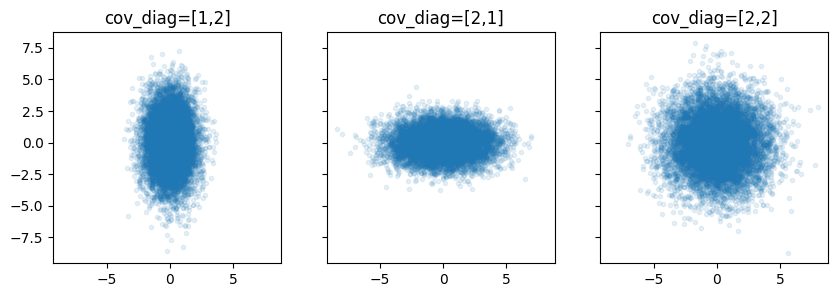

In [20]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))

titles = ["cov_diag=[1,2]", "cov_diag=[2,1]", "cov_diag=[2,2]"]
for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.scatter(
        plt_sample_batch[:, i, 0], plt_sample_batch[:, i, 1], alpha=0.1, marker="."
    )
    ax.set_title(title)

### Multivariate gaussian with full covariance

- spherical/isotropic Gaussian (when variance is the same for each component $\Sigma = \sigma^2I$)


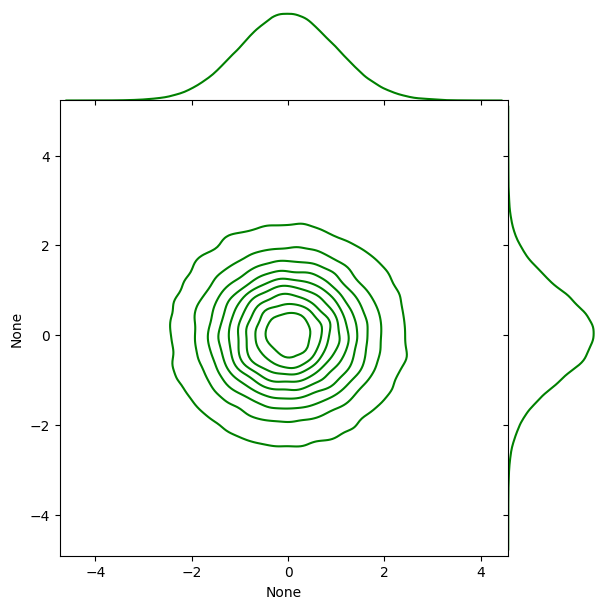

In [21]:
s2d_gaussian = tfd.MultivariateNormalDiag(loc=[0.0, 0.0])

x = s2d_gaussian.sample(100000)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x=x1, y=x2, kind="kde", space=0, color="g")

- `tfd.MutivariateNormalTriL` requires:
  - `loc`: floats corresponding to $\mu$
  - `scale_tril`: lower-triangular matrix $L$ such that $\Sigma = LL^T$
- Covariance matrix: a matrix where the diagonal entries are the variances of each variable and the off-diagonal entries are the covariances between each pair of variables. i.e.,

\begin{equation}
\begin{bmatrix}
var(x) & cov(x, y) \\
cov(x, y) & var(x)

\end{bmatrix}
\end{equation}

- The covariance matrix must be symmetric and positive semi-definite. (A symmetric matrix $M \in \mathbb{R}^{d\times d}$ is positive semi-definite if it satisfies $b^TMb \ge 0$ for all nonzero $b\in\mathbb{R}^d$. If, in addition, we have $b^TMb = 0 \Rightarrow b=0$ then $M$ is positive definite.) --> cholesky decomposition for computing covariance matrix: For every real-valued symmetric positive-definite matrix M, there is a unique lower-diagonal matrix $L$ that has positive diagonal entries for which $LL^T = M$
- If the matrix is only positive semi-definite, the Cholesky decomposition exists but is not unique. For covariance matrices, this corresponds to the degenerate case where the probability density function collapses to a subspace of the event space.
- If the covariance matrix for the multivariate Guassian distribution is positive-definite, then an algorithm that computes the Cholesky decomposition of $\Sigma$ returns a lower-triangular matrix $L$ such that $LL^T = \Sigma$. The $L$ can be passed to `tfd.MultivariateNormalTriL` as the `scale_tril` argument.


In [22]:
scale_tril = [
    [
        1.0,
        0.0,
    ],
    [0.6, 0.8],
]

tf.matmul(tf.constant(scale_tril), tf.transpose(tf.constant(scale_tril)))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1. , 0.6],
       [0.6, 1. ]], dtype=float32)>

In [23]:
non_spherical_2d_gaussian = tfd.MultivariateNormalTriL(
    loc=[0, 0], scale_tril=scale_tril
)

non_spherical_2d_gaussian.mean(), non_spherical_2d_gaussian.covariance()

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1. , 0.6],
        [0.6, 1. ]], dtype=float32)>)

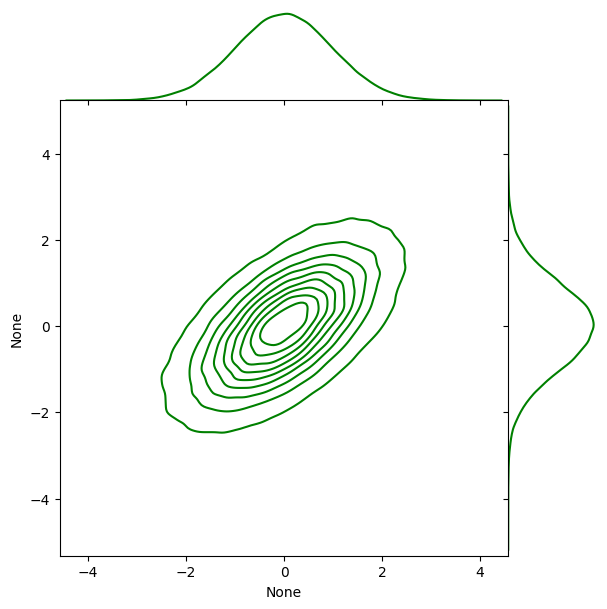

In [24]:
x = non_spherical_2d_gaussian.sample(100000)
x1 = x[:, 0]
x2 = x[:, 1]
sns.jointplot(x=x1, y=x2, kind="kde", space=0, color="g")

In [25]:
sigma = [[10.0, 5.0], [5.0, 10.0]]

tf.linalg.cholesky(sigma)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.1622777, 0.       ],
       [1.5811388, 2.738613 ]], dtype=float32)>

In [26]:
tf.linalg.matmul(scale_tril, tf.transpose(scale_tril))  # LL^T = Sigma

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1. , 0.6],
       [0.6, 1. ]], dtype=float32)>

In [27]:
# Try to compute the Cholesky decomposition for a matrix with negative eigenvalues

bad_sigma = [[10.0, 11.0], [11.0, 10.0]]

try:
    scale_tril = tf.linalg.cholesky(bad_sigma)
except Exception as e:
    print(e)

2023-12-26 02:17:41.605878: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


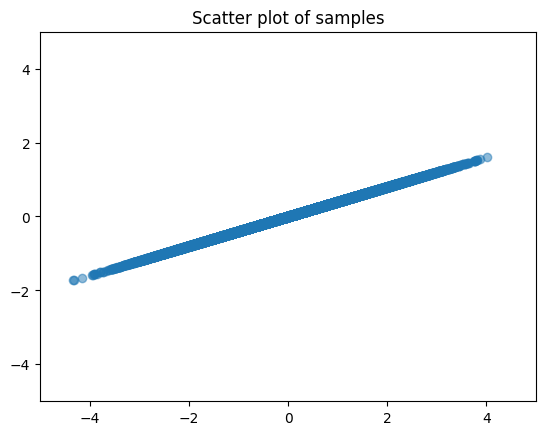

In [28]:
# semi definite covariance matrix
psd_mvn = tfd.MultivariateNormalTriL(
    loc=[0.0, 0.0], scale_tril=[[1.0, 0.0], [0.4, 0.0]]
)

x = psd_mvn.sample(100000)
x1 = x[:, 0]
x2 = x[:, 1]
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Scatter plot of samples")
plt.scatter(x1, x2, alpha=0.5)

In [29]:
# tf.linalg.cholesky will also fail for positive semi-definite but not positive definite matrics

another_bad_sigma = [[10.0, 0.0], [0.0, 0.0]]

try:
    scale_tril = tf.linalg.cholesky(another_bad_sigma)
except Exception as e:
    print(e)

2023-12-26 02:17:41.803037: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


To create a multivariate Gaussian distribution with full covariance you need to:

1. Specify parameters $\mu$ and either $\Sigma$ (a symmetric positive definite matrix) or $L$ (a lower triangular matrix with positive diagonal elements), such that $\Sigma = LL^T$.

2. If only $\Sigma$ is specified, compute `scale_tril = tf.linalg.cholesky(sigma)`.

3. Create the distribution: `multivariate_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)`.


In [30]:
# Create a multivariate Gaussian distribution

mu = [1.0, 2.0, 3.0]
sigma = [[0.5, 0.1, 0.1], [0.1, 1.0, 0.6], [0.1, 0.6, 2.0]]

scale_tril = tf.linalg.cholesky(sigma)

multivariate_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)

# Check the covariance matrix
multivariate_normal.covariance(), multivariate_normal.mean()

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.49999997, 0.1       , 0.1       ],
        [0.1       , 1.0000001 , 0.6       ],
        [0.1       , 0.6       , 2.        ]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>)

- Reinterpreting a batch of independent distributions over an event space as a single joint distribution over a product of event spaces


In [31]:
bn = tfd.Normal(loc=[-1, 0.5], scale=[1, 1.5])

# bn: distribution object
# reinterpreted_batch_ndims=1 --> 1 batch dimension
independent_normal = tfd.Independent(bn, reinterpreted_batch_ndims=1)
print(independent_normal)

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[2], dtype=float32)


In [32]:
probs = 0.5 * tf.ones((2, 4, 5))
dist = tfd.Independent(tfd.Bernoulli(probs=probs))
tfd.Bernoulli(probs=probs), dist, dist.log_prob(np.zeros((4, 5)))

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[2, 4, 5] event_shape=[] dtype=int32>,
 <tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[2] event_shape=[4, 5] dtype=int32>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-13.862944, -13.862944], dtype=float32)>)

## The independent distribution


In [33]:
locs = [-1, 1]
scales = [0.5, 1]
batch_normals = tfd.Normal(loc=locs, scale=scales)

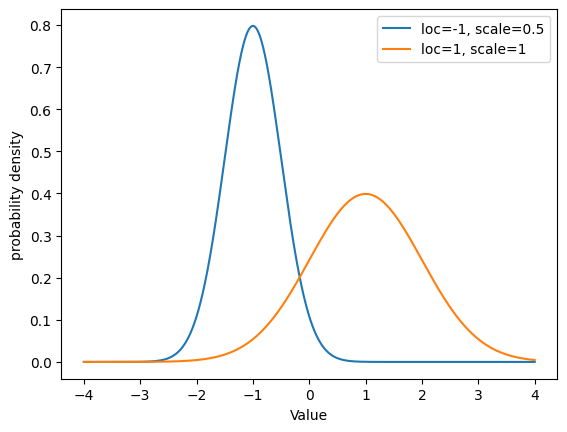

In [34]:
t = np.linspace(-4, 4, 10000)
densities = batch_normals.prob(np.repeat(t[:, np.newaxis], 2, axis=1))

sns.lineplot(x=t, y=densities[:, 0], label=f"loc={locs[0]}, scale={scales[0]}")
sns.lineplot(x=t, y=densities[:, 1], label=f"loc={locs[1]}, scale={scales[1]}")
plt.xlabel("Value")
plt.ylabel("probability density")
plt.legend()
plt.show()

In [35]:
bivariate_normal_from_independent = tfd.Independent(
    batch_normals, reinterpreted_batch_ndims=1
)
bivariate_normal_from_independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

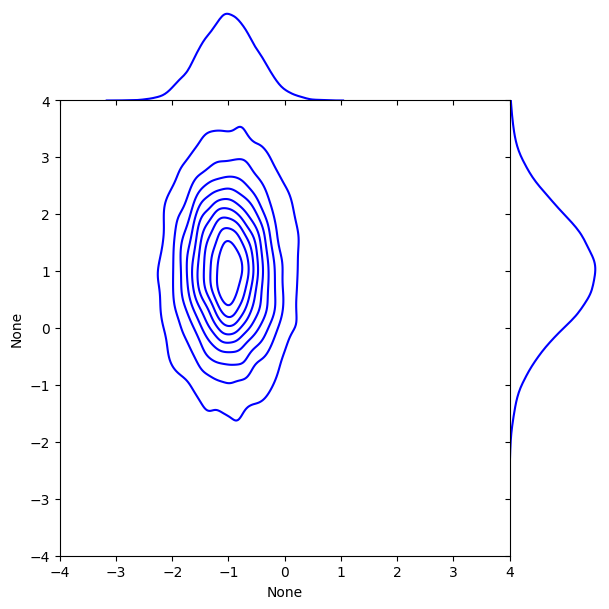

In [36]:
samples = bivariate_normal_from_independent.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x=x1, y=x2, kind="kde", space=0, color="b", xlim=[-4, 4], ylim=[-4, 4])

In [37]:
bivariate_normal_from_multivariate = tfd.MultivariateNormalDiag(loc = locs, scale_diag=scales)
bivariate_normal_from_multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [38]:
# shifting batch dimensions to event dimensions
loc_grid = [[-100, -100],
            [100, 100],
            [0, 0]]

scale_grid = [[1, 10],
              [1, 10],
              [1, 1]]

normal_bach_3by2_event_1 = tfd.Normal(loc = loc_grid, scale=scale_grid)
normal_bach_3by2_event_1

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [39]:
normal_batch_3_event_2 = tfd.Independent(normal_bach_3by2_event_1,
                                         reinterpreted_batch_ndims=2)
normal_batch_3_event_2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [40]:
normal_batch_3_event_2.log_prob(value=[[-10, 10],
                                       [100, 100,],
                                       [1, 1]])

<tf.Tensor: shape=(), dtype=float32, numpy=-4121.619>

In [41]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
newsgroup_data = fetch_20newsgroups()

In [43]:
print(newsgroup_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [44]:
print(newsgroup_data['data'][0])
newsgroup_data['target'][0], newsgroup_data['target_names'][newsgroup_data['target'][0]]

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


(7, 'rec.autos')

In [45]:
n_documents = len(newsgroup_data['data'])
cv = CountVectorizer(input = 'content',
                     binary=True,
                     max_df=0.25,
                     min_df=1.01/n_documents)
binary_bow = cv.fit_transform(newsgroup_data['data'])

In [46]:
binary_bow.shape

(11314, 56365)

In [47]:
cv.inverse_transform(binary_bow[0, :])

[array(['lerxst', 'wam', 'umd', 'where', 'thing', 'car', 'rac3',
        'maryland', 'college', 'park', '15', 'wondering', 'anyone',
        'could', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked',
        'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors',
        'were', 'really', 'small', 'addition', 'front', 'bumper',
        'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine',
        'specs', 'years', 'production', 'made', 'history', 'whatever',
        'info', 'funky', 'looking', 'please', 'mail', 'thanks', 'il',
        'brought', 'neighborhood'], dtype='<U80')]

In [48]:
inv_vocab = {v: k for k, v in cv.vocabulary_.items()}

In [49]:
n_class = newsgroup_data['target'].max() + 1
y = newsgroup_data['target']
n_words = binary_bow.shape[1]

alpha = 1e-6 # smoothing term

theta = np.zeros([n_class, n_words])

for c_k in range(n_class):
    class_mask = (y == c_k)
    N = class_mask.sum()
    theta[c_k, :] = (binary_bow[class_mask, :].sum(axis=0) + alpha) / (N + alpha*2)

In [50]:
most_probable_word_idx = theta.argmax(axis=1)

for j, ix in enumerate(most_probable_word_idx):
    print(f"Most probable word in class {newsgroup_data['target_names'][j]} is {inv_vocab[ix]}")

Most probable word in class alt.atheism is people
Most probable word in class comp.graphics is graphics
Most probable word in class comp.os.ms-windows.misc is windows
Most probable word in class comp.sys.ibm.pc.hardware is thanks
Most probable word in class comp.sys.mac.hardware is mac
Most probable word in class comp.windows.x is window
Most probable word in class misc.forsale is sale
Most probable word in class rec.autos is car
Most probable word in class rec.motorcycles is dod
Most probable word in class rec.sport.baseball is he
Most probable word in class rec.sport.hockey is ca
Most probable word in class sci.crypt is clipper
Most probable word in class sci.electronics is use
Most probable word in class sci.med is reply
Most probable word in class sci.space is space
Most probable word in class soc.religion.christian is god
Most probable word in class talk.politics.guns is people
Most probable word in class talk.politics.mideast is people
Most probable word in class talk.politics.mi

In [51]:
batch_of_bernoullis = tfd.Bernoulli(probs = theta)
px_given_y = tfd.Independent(batch_of_bernoullis,
                             reinterpreted_batch_ndims=1)
px_given_y

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[20] event_shape=[56365] dtype=int32>

In [52]:
n_samples = 10
sample = px_given_y.sample(n_samples)
sample.shape

TensorShape([10, 20, 56365])

In [53]:
chosen_class=15
newsgroup_data['target_names'][chosen_class]

'soc.religion.christian'

In [54]:
class_sample = sample[:, chosen_class, :]
class_sample

<tf.Tensor: shape=(10, 56365), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [55]:
cv.inverse_transform(class_sample)[0]

array(['10', '13', '16', '17', '21', '30', '30602', 'ability', 'abundant',
       'according', 'adam', 'address', 'allowed', 'anyhow', 'appears',
       'apr', 'arrogance', 'astrophysics', 'authority', 'aware',
       'becoming', 'been', 'believe', 'believeth', 'berkeley', 'bible',
       'bloodline', 'books', 'choose', 'christians', 'college', 'coming',
       'company', 'couldn', 'darius', 'deceitful', 'deep', 'defective',
       'details', 'did', 'disobedience', 'distinctives', 'dr', 'drawer',
       'even', 'facetiously', 'faith', 'first', 'fraser', 'go', 'goal',
       'good', 'had', 'happen', 'hate', 'hey', 'his', 'interpret',
       'keeps', 'language', 'law', 'lives', 'looked', 'looks', 'los',
       'lose', 'mail', 'matthew', 'meaning', 'melinda', 'method', 'must',
       'net', 'new', 'observance', 'opinion', 'our', 'own', 'papal',
       'pardon', 'particularly', 'paul', 'post', 'pre', 'programs',
       'reconcile', 'remained', 'reply', 'resolve', 'rest', 'robertson',
     

## sampling and log probs

In [56]:
loc = [[[0.3, 1.5, 1], [0.2, 0.4, 2.8]],
       [[2, 2.3, 8], [1.4, 1, 1.3]]]
scale_diag = [0.4, 1, 0.7]

nd = tfd.MultivariateNormalDiag(loc = loc, scale_diag=scale_diag)
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2, 2] event_shape=[3] dtype=float32>

In [57]:
np.asarray(loc).shape, np.asarray(scale_diag).shape

((2, 2, 3), (3,))

In [58]:
ind = tfd.Independent(nd, reinterpreted_batch_ndims=1)
ind

<tfp.distributions.Independent 'IndependentMultivariateNormalDiag' batch_shape=[2] event_shape=[2, 3] dtype=float32>

In [59]:
ind.sample(5).shape

TensorShape([5, 2, 2, 3])

In [60]:
inp = tf.random.uniform((2, 2, 3))
ind.log_prob(inp)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -8.461753, -74.31184 ], dtype=float32)>

In [61]:
# `[E]` shaped input (broadcasting over batch size )
inp = tf.random.uniform((2, 3))
ind.log_prob(inp)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-11.374424, -65.50334 ], dtype=float32)>

In [62]:
# `[S, B, E]` shaped input (broadcasting over samples)
inp = tf.random.uniform((9, 2, 2, 3))
ind.log_prob(inp)

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[ -9.707806 , -72.61035  ],
       [ -9.125061 , -73.57226  ],
       [-11.427725 , -71.02061  ],
       [ -7.1911087, -71.90066  ],
       [ -9.661385 , -65.69953  ],
       [ -8.851298 , -64.28472  ],
       [-11.380716 , -82.626915 ],
       [-11.541152 , -70.33756  ],
       [ -9.031519 , -70.81494  ]], dtype=float32)>

In [63]:
# `[S, b, e]` shaped input, where [b, e] is broadcastable over [B, E]
inp = tf.random.uniform((5, 1, 2, 1))
ind.log_prob(inp)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ -9.553913 , -62.009747 ],
       [-10.156163 , -79.86974  ],
       [-12.3194475, -65.54766  ],
       [ -9.274924 , -69.87284  ],
       [-10.401653 , -82.48941  ]], dtype=float32)>

In [64]:
# Making a function get_data which:
#   1) Fetches the 20 newsgroup dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):
    
    newsgroups_train_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                               subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                              subset='test', categories=categories)

    n_documents = len(newsgroups_train_data['data'])
    count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents)
    
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data'])
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data']) 

    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),  (test_binary_bag_of_words.todense(), newsgroups_test_data['target'])

# Defining a function to conduct Laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class.

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameters for Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

    return theta

# Getting a subset of the 20 newsgroup dataset

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories=categories)
smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

# Function which computes the prior probability of every class based on frequency of occurence in 
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts / np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

# process of NB classifier: 
# 1) get the clas priors
# 2) get class conditional distributions
# 3) actually classify
priors = class_priors(n_classes=len(categories), labels=train_labels)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [65]:
def make_distribution(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs)
    dist = tfd.Independent(batch_of_bernoullis,
                           reinterpreted_batch_ndims=1)
    return dist

tf_dist = make_distribution(smoothed_counts)
tf_dist

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[4] event_shape=[17495] dtype=int32>

In [66]:
# 1) Computes the class conditional probabilities given the sample
# 2) form the joint lokelihood
# 3) normalize the joint likelihood and return the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors, dtype="float32"), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor 

    return log_prob

In [83]:
priors

array([0.2359882 , 0.28711898, 0.29154376, 0.18534907])

In [80]:
cond_probs = tf_dist.log_prob(test_data[0])
joint_likelihood = tf.add(np.log(priors, dtype="float32"), cond_probs)
norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
log_prob = joint_likelihood - norm_factor 

cond_probs, joint_likelihood, norm_factor, log_prob

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-252.67094, -191.13084, -202.76599, -254.021  ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-254.11491, -192.37871, -203.99855, -255.70651], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-192.3787], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=
 array([-6.1736221e+01, -1.5258789e-05, -1.1619858e+01, -6.3327820e+01],
       dtype=float32)>)

In [78]:
len(test_data)

1353

In [69]:
priors, dist

(array([0.2359882 , 0.28711898, 0.29154376, 0.18534907]),
 <tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[2] event_shape=[4, 5] dtype=int32>)

In [67]:
log_probs = predict_sample(tf_dist, test_data[0], priors)
log_probs

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-6.1736221e+01, -1.5258789e-05, -1.1619858e+01, -6.3327820e+01],
      dtype=float32)>

In [82]:
from sklearn.metrics import f1_score
probabilities = []
for sample, label in zip(test_data, test_labels):
    probabilities.append(tf.exp(predict_sample(tf_dist, sample, priors)))

In [ ]:
probabilities = np.asarray(probabilities)
predicted_classes = np.argmax(probabilities, axis=-1)
print(f"f1: {f1_score(test_labels, predicted_classes, average='macro')}")

In [35]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(alpha=1)
clf.fit(np.asarray(train_data), train_labels)
pred = clf.predict(np.asarray(test_data))
print(f"f1 (sklearn): {f1_score(test_labels, pred, average='macro')}")

f1 (sklearn): 0.7848499112849504


## learnable distribution

In [ ]:
normal = tfd.Normal(loc=tf.Variable(0, name='loc'), scale=1)

def nll(x_train):
    # negative log likelihood 
    return -tf.reduce_mean(normal.log_prob(x_train))

@tf.function
def get_loss_grads(x_train):
    with tf.GradientTape() as tape:
        tape.watch(normal.trainable_variables)
        loss = nll(x_train)
    grads = tape.gradient(loss, normal.trainable_variables)
    return loss, grads

### training loop 
# optim = tf.keras.optimizers.SGD(learning_rate = 0.05)

# num_steps = 100
# x_samples = ...

# for _ in range(num_steps):
#     loss, grads = get_loss_grads(x_samples)
#     optim.apply_gradients(zip(grads, normal.trainable_variables))

In [84]:
# define exponential distribution
exp = tfd.Exponential(rate = 0.3, name = 'exp')

# define an exponential distribution with a trainable rate parameter
exp_train = tfd.Exponential(rate=tf.Variable(1., name='rate'), name='exp_train') 

def nll(x_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(x_train))

@tf.function
def get_loss_grads(x_train, distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(x_train, distribution)
        grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

def exp_dist_optimization(data, distribution):
    
    train_loss, train_rate = [], []
    optim = tf.keras.optimizers.SGD(learning_rate=0.05)

    num_steps = 10

    for i in range(num_steps):
        loss, grads = get_loss_grads(data, distribution)
        optim.apply_gradients(zip(grads, distribution.trainable_variables))

        rate_val = distribution.rate.value() 
        train_loss.append(loss)
        train_rate.append(rate_val)

        print(f"Step: {i}, loss: {loss}, rate: {rate_val}")
    return train_loss, train_rate

sampled_data = exp.sample(10000)
train_loss, train_rate = exp_dist_optimization(sampled_data, exp_train)

Step: 0, loss: 3.3447906970977783, rate: 0.8827604055404663
Step: 1, loss: 3.077349901199341, rate: 0.7721613049507141
Step: 2, loss: 2.8412795066833496, rate: 0.6696749925613403
Step: 3, loss: 2.640885353088379, rate: 0.5770984888076782
Step: 4, loss: 2.480015993118286, rate: 0.4964991807937622
Step: 5, loss: 2.360858917236328, rate: 0.4299646317958832
Step: 6, loss: 2.282193660736084, rate: 0.3790135979652405
Step: 7, loss: 2.2379043102264404, rate: 0.3436953127384186
Step: 8, loss: 2.217588186264038, rate: 0.3219332993030548
Step: 9, loss: 2.2102103233337402, rate: 0.3100052773952484


In [41]:
pred_val = exp_train.rate.numpy()
exact = exp.rate.numpy()
pred_val, exact

(0.32220235, 0.3)

In [45]:
# Now we learn the distribution using gradient tape

def make_distribution_withGT(data, labels, nb_classes):

    class_data = []
    train_vars = []
    distributions = []
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(low=0.01, high =0.1, size=data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask, :])

    for c_num in range(0,nb_classes):
        optimizer = tf.keras.optimizers.legacy.Adam()
        print('\n%-------------------%')
        print('Class ', c_num)
        print('%-------------------%')

        for i in range(0,100):
            loss, grads = get_loss_grads(class_data[c_num], distributions[c_num])
            if(i % 10 == 0):
                print(f"Iter: {i}, loss: {loss}")
            optimizer.apply_gradients(zip(grads, distributions[c_num].trainable_variables))
            eta = 1e-3
            clipped_probs = tf.clip_by_value(distributions[c_num].trainable_variables,
                                             clip_value_min = eta, clip_value_max=1)
            train_vars[c_num] = tf.squeeze(clipped_probs)

    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist,reinterpreted_batch_ndims=1)

    print(dist)

    return dist

In [46]:
# Make the same Naive Bayes classifier we did last tutorial

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)

smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

priors = class_priors(n_classes=len(categories), labels=train_labels)
tf_dist = make_distribution(smoothed_counts)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [47]:
# Now train the distributions with gradient tape

GT_dist = make_distribution_withGT(data=train_data, labels=train_labels, nb_classes=4)


%-------------------%
Class  0
%-------------------%
Iter: 0, loss: 0.07856931765800161
Iter: 10, loss: 0.06919858791782794
Iter: 20, loss: 0.060456266757603586
Iter: 30, loss: 0.05236741943863067
Iter: 40, loss: 0.04488279783323363
Iter: 50, loss: 0.03795896523831472
Iter: 60, loss: 0.03156345979676073
Iter: 70, loss: 0.025645111338609364
Iter: 80, loss: 0.020165209557141118
Iter: 90, loss: 0.015081077537521182

%-------------------%
Class  1
%-------------------%
Iter: 0, loss: 0.07162499806150646
Iter: 10, loss: 0.062271630233990086
Iter: 20, loss: 0.05348529199113434
Iter: 30, loss: 0.045325155853061704
Iter: 40, loss: 0.03774296475096591
Iter: 50, loss: 0.03071812743322872
Iter: 60, loss: 0.024239557629419047
Iter: 70, loss: 0.018266033024947018
Iter: 80, loss: 0.012749526693523949
Iter: 90, loss: 0.00764526499482687

%-------------------%
Class  2
%-------------------%
Iter: 0, loss: 0.07876047334601245
Iter: 10, loss: 0.06965085567496038
Iter: 20, loss: 0.06126777915607566
Iter

In [49]:
for dist in [GT_dist, tf_dist]:
    probabilities = []
    for sample, label in zip(test_data, test_labels):
        probabilities.append(predict_sample(dist, sample, priors))
    
    probabilities = np.asarray(probabilities)
    predicted_classes = np.argmax(probabilities, axis = -1)
    print(f"f1: {f1_score(test_labels, predicted_classes, average='macro')}")

f1: 0.8281217887474945
f1: 0.7848499112849504


## distribution lambda layer

In [4]:
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(1, input_shape=(2,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1),
        convert_to_tensor_fn = tfd.Distribution.sample 
    )
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss = nll, optimizer='rmsprop')
model.fit(x-train, y_train)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_shape=(12,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Bernoulli(logits=t)
    )
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 distribution_lambda_2 (Dis  ((None, 8),               0         
 tributionLambda)             (None, 8))                         
                                                                 
Total params: 104 (416.00 Byte)
Trainable params: 104 (416.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


4/4 [==============================] - 0s 730us/step


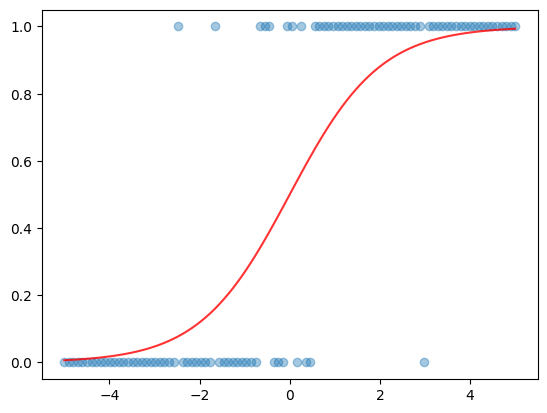

In [10]:
model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    # parameterize the sigmoid using bernoulli distribution
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)
]) 

# forward and plot
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color="r", alpha=0.8)
plt.show()

16/16 [==============================] - 0s 533us/step


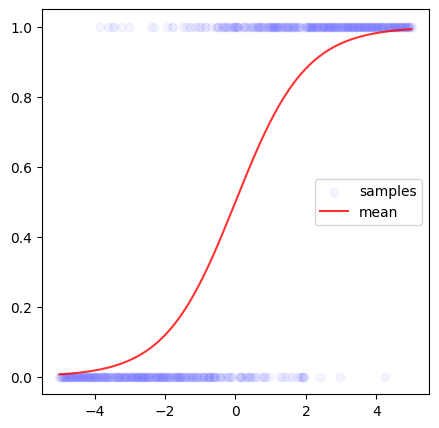

In [11]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 29.06it/s]


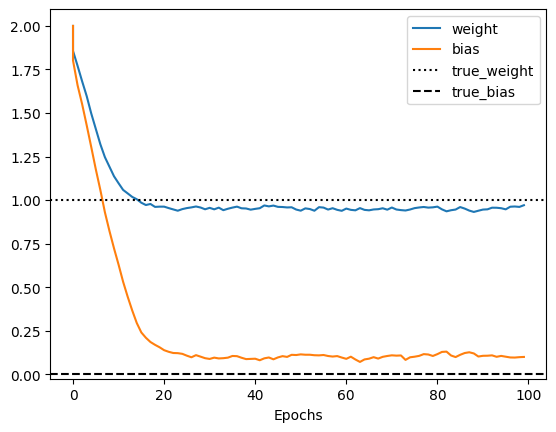

In [12]:
from tensorflow.keras.optimizers import RMSprop

model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    # parameterize the sigmoid using bernoulli distribution
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)
]) 

# define loss function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true) 

model_untrained.compile(loss = nll, 
                        optimizer = RMSprop(learning_rate=0.01))

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in tqdm(range(100)):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Probabilistic layers

In [ ]:
# probablistic layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Normal(loc = t[..., :1],
                       scale=tf.math.softplus(t[..., 1:])),
        )
    )
    # tfpl.IndependentNormal(1) # event shape 1
]) 

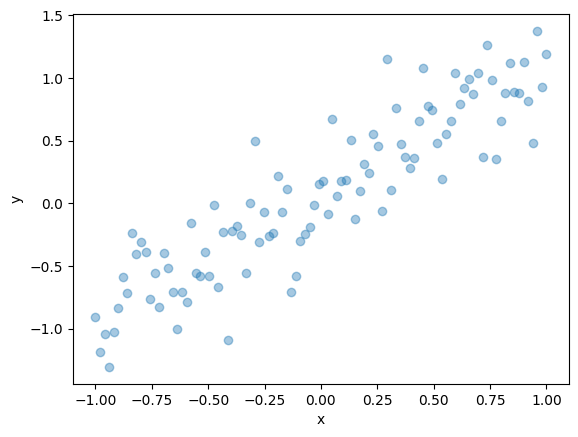

In [13]:
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==============================] - 0s 570us/step


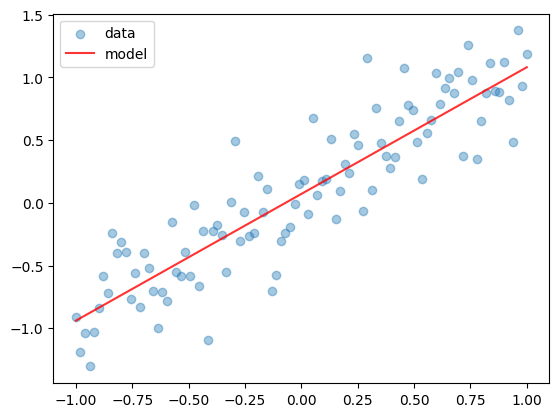

In [14]:
from tensorflow.keras.losses import MeanSquaredError

# LINEAR LEAST SQUARE MODEL (DETERMINISTIC LINEAR REGRESSION)
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [22]:
# probabilistic linear regression modeling aleatoric uncertainty

event_shape = 1

model = Sequential(
    [
        # units = 2 to model both mean and variance
        Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
        tfpl.DistributionLambda(
            # take out from dense layer to parameterize the mean and not the variance
            lambda t: tfd.Independent(
                tfd.Normal(loc=t[..., :1], 
                           scale=tf.math.softplus(t[..., 1:])) # parameterize standard deviation
            )
        )
        # returns a single distribution object
        # DistributionLambda can also be written as: 
        # tfpl.IndependentNormal(event_shape = 1)
    ]
)

model.compile(
    loss=lambda y_true, y_pred: -y_pred.log_prob(y_true),
    optimizer=RMSprop(learning_rate=0.005),
)

model.fit(x_train, y_train, epochs=200, verbose=False)

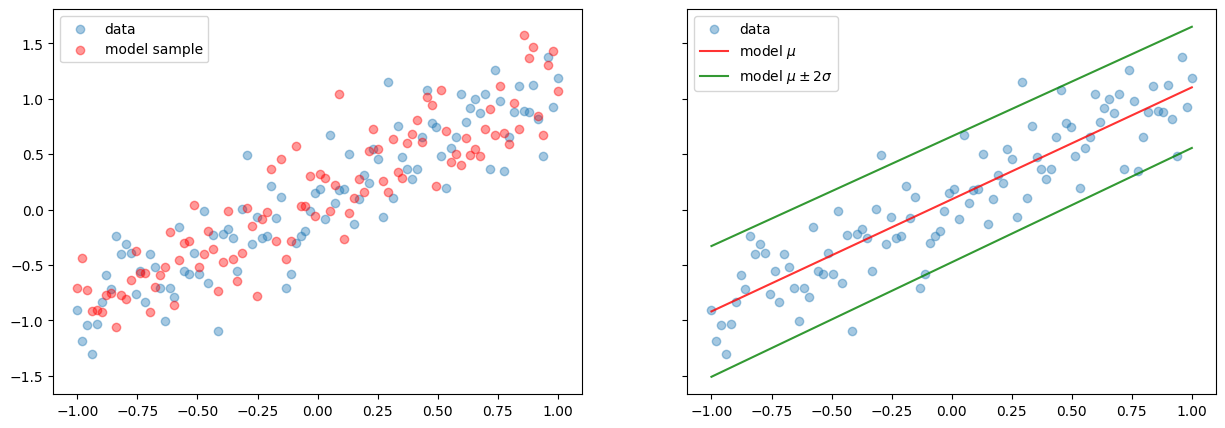

In [23]:
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

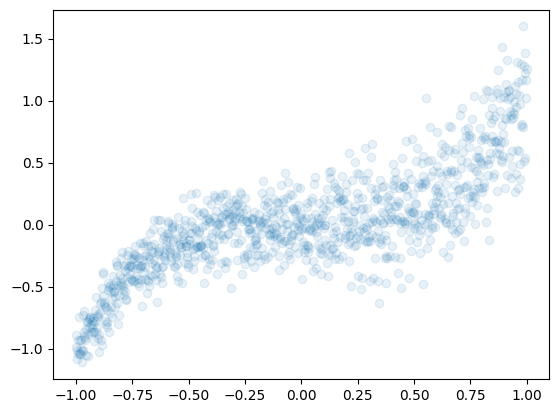

In [24]:
# non-linear regression
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [25]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 16        
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
 independent_normal (Indepe  ((None, 1),               0         
 ndentNormal)                 (None, 1))                         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 579us/step - loss: -0.1081


-0.1080828458070755

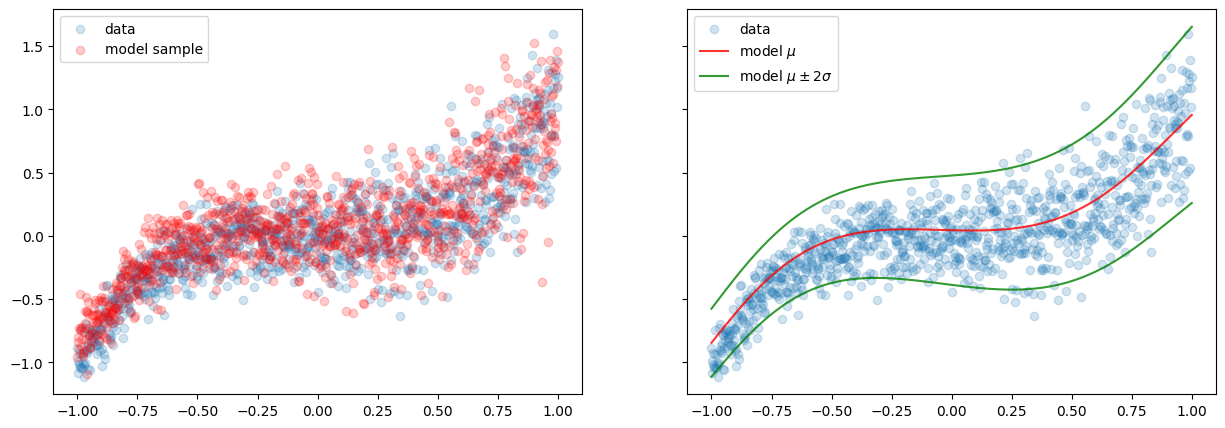

In [26]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

### Bayes by backprop

bayes backprop to model epistemic uncertainty: changing each weight from a singluar deterministic value to a probability distribution and learn the parameters of the distribution, that is, in traditional deterministic NN, $w_i = \hat{w}_i$, but NN with weight uncertainty represented by normal distribution: $w_i \sim \mathcal{N}(\hat{\mu_i}, \hat{\sigma_i})$

Feedforward single value: 
- Sample each network weight from their respective distributions --> gives a single set of network weights
- Use these weights to determine a feedforward value $\hat{y}_i$

Bayesian methods can be used to calculate the distribution of a model parameter given some data. In the context of weight uncertainty in NNs, this is convenient, since we are looking for the distribution of weights (model parameters) given some (training) data. The key step relies on Bayes' theorem. This theorem states, in mathematical notation, that

$$ P(w | D) = \frac{P(D | w) P(w)}{\int P(D | w') P(w') \text{d}w'} $$

where the terms mean the following:
- $D$ is some data, e.g. $x$ and $y$ value pairs: $D = \{(x_1, y_1), \ldots, (x_n, y_n)\}$. This is sometimes called the *evidence*.
- $w$ is the value of a model weight.
- $P(w)$ is called the *prior*. This is our "prior" belief on the probability density of a model weight, i.e. the distribution that we postulate before seeing any data.
- $P(D | w)$ is the *likelihood* of having observed data $D$ given weight $w$. It is precisely the same likelihood we discussed in the previous reading and is used to calculate the negative log-likelihood.
- $P(w | D)$ is the *posterior* density of the distribution of the model weight at value $w$, given our training data.  It is called *posterior* since it represents the distribution of our model weight *after* taking the training data into account.
- 
The term ${\int P(D | w') P(w') \text{d}w'} = P(D)$ does not depend on $w$ (as the $w'$ is an integration variable). It is only a normalisation term. For this reason, the Bayes' theorem will be written as: 

$$ P(w | D) = \frac{P(D | w) P(w)}{P(D)}. $$

Bayes' theorem gives us a way of combining data with some "prior belief" on model parameters to obtain a distribution for these model parameters that considers the data, called the *posterior distribution*.

Determining the distribution of each weight in the NN: 
1. Pick prior density $P(w)$
2. Use data $D$ to calculate likelihood $P(D | w)$
3. Determine posterior density $P(w | D)$ using Bayes' theorem, resulting in NN weights (but $P(w | D)$ is difficult to calculate, and therefore we use variational Bayes)
   
Variational Bayes:
- Uses variational posterior ($q(w | \theta)$) to approximate posterior distribution with a second function with parameter $\theta$ (does this mean $q(w | \theta) \rightarrow P(w | D)$?)
- Use K-L divergence ($D_{KL}$) to measure and minimize the difference between the two distributions, which is defined as : 
$$ D_{KL} (f(x) || g(x)) = \int f(x) \text{log}(\frac{f(x)}{g(x)})dx$$
(KL Divergence should be non-negative)
- Setting D as constant, the KL divergence between $q(w | \theta)$ and $P(w | D)$ is:

$$
\begin{align}
D_{KL} (q(w | \theta) || P(w | D)) &= \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w | D)} \right) \text{d} w \\
&= \int q(w | \theta) \log \left( \frac{q(w | \theta) P(D)}{P(D | w) P(w)} \right) \text{d} w \\
&= \underbrace{\int q(w | \theta) \log P(D) \text{d} w}_{q(w | \theta) \text{integrates to 1}} + \int q(w | \theta) \log \left( \frac{q(w | \theta)}{P(w)} \right) \text{d} w - \int q(w | \theta) \log P(D | w) \text{d} w \\
&= \underbrace{\log P(D)}_{\text{D is constant}} + D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w))
\end{align}
$$

$L(\theta | D) = D_{\text{KL}}(q(w | \theta) || P(w)) - \mathbb{E}_{q(w | \theta)} ( \text{log} P(D|w)) $

- Complexity cost: KL diergence between $q(w | \theta)$ and prior $P(w)$
- Likelihood cost: Expectation of NLL under variational posterior

Then, the objective is to minimize the loss function $L(\theta | D)$ to determine $\theta$

$$
\begin{align}
\log P(D) &= \mathbb{E}_{q(w | \theta)}(\log P(D | w)) - D_{KL} ( q(w | \theta) || P(w) ) + D_{KL} (q(w | \theta) || P(w | D))\\
&\ge \mathbb{E}_{q(w | \theta)}(\log P(D | w)) - D_{KL} ( q(w | \theta) || P(w) ) =: ELBO
\end{align}
$$ 

ELBO is negative of loss function, minimizing the loss func is maximizing ELBO --> Bayesian by backpropagation. Steps: 
1. Assign weight with prior distribution with density $P(w)$, which usually has no trainable parameters
2. Assign weight a variational posteriod with density $q(w|\theta)$ with trainable parameters $\theta$
3. Determine $\theta$ by updating it in direction that minimize loss func: 
$$
\begin{align}
L(\theta | D) &= D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w)) \\
&= \underbrace{\int q(w | \theta) ( \log q(w | \theta) - \log P(D | w) - \log P(w) ) \text{d}w}_{\text{This is computationall expensive so we use Monte Carlo approximation, whereas:} } \\
\mathbb{E}_{q(w | theta)(log q(w|\theta) - \text{log} P(D|w) - \text{log}P(w))}
\end{align} 
$$
4. Reparameterization trick: taking derivatives w.r.t. $\theta$ is difficult --> move the ependence on $\theta$ around so that an expectation may be taken independently of it. Using Gaussian as variational posterior: 

$$
\begin{align}
\mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \int q(w | \mu, \sigma) f(w; \mu, \sigma) \text{d}w \\
&= \int \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2 \sigma^2} (w - \mu)^2 \right) f(w; \mu, \sigma) \text{d}w \\
&= \int \frac{1}{\sqrt{2 \pi}} \exp \left( -\frac{1}{2} \epsilon^2 \right) f \left( \mu + \sigma \epsilon; \mu, \sigma \right) \text{d}\epsilon \\
&= \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( \mu + \sigma \epsilon; \mu, \sigma \right) )
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial \mu} \mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \frac{\partial}{\partial \mu} \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( w; \mu, \sigma \right) ) = \mathbb{E}_{\epsilon \sim N(0, 1)} \frac{\partial}{\partial \mu} f \left( \mu + \sigma \epsilon; \mu, \sigma \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial \sigma} \mathbb{E}_{q(w | \mu, \sigma)} (f(w; \mu, \sigma) ) &= \frac{\partial}{\partial \sigma} \mathbb{E}_{\epsilon \sim N(0, 1)} (f \left( w; \mu, \sigma \right) ) = \mathbb{E}_{\epsilon \sim N(0, 1)} \frac{\partial}{\partial \sigma} f \left( \mu + \sigma \epsilon; \mu, \sigma \right)
\end{align}
$$

Using Monte Carlo estimate: 
$$
\begin{align}
\mathbb{E}_{\epsilon \sim N(0, 1)}  \frac{\partial}{\partial \theta} f \left( \mu + \sigma \epsilon; \mu, \sigma \right) \approx \sum_{i}  \frac{\partial}{\partial \theta} f \left( \mu + \sigma \epsilon_i; \mu, \sigma \right),\qquad \epsilon_i \sim N(0, 1).
\end{align}
$$

### Implementation

Putting this all together, for our loss function $L(\theta | D) \equiv L(\mu, \sigma | D)$, we have 

$$
f(w; \mu, \sigma) = \log q(w | \mu, \sigma) - \log P(D | w) - \log P(w)
$$

$$
\begin{align}
\frac{\partial}{\partial \mu} L(\mu, \sigma | D) \approx \sum_{i} \left( \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} + \frac{\partial f(w_i; \mu, \sigma)}{\partial \mu} \right)
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial \sigma} L(\mu, \sigma | D) \approx \sum_{i} \left( \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} \epsilon_i + \frac{\partial f(w_i; \mu, \sigma)}{\partial \sigma} \right)
\end{align}
$$

$$
f(w; \mu, \sigma) = \log q(w | \mu, \sigma) - \log P(D | w) - \log P(w)
$$

where $w_i = \mu + \sigma \epsilon_i, \, \epsilon_i \sim N(0, 1)$. In practice, we often only take a single sample $\epsilon_1$ for each training point. This leads to the following backpropagation scheme:
1. Sample $\epsilon_i \sim N(0, 1)$.
2. Let $w_i = \mu + \sigma \epsilon_i$
3. Calculate 
$$
\nabla_{\mu}f = \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} + \frac{\partial f(w_i; \mu, \sigma)}{\partial \mu} \hspace{3em} \nabla_{\sigma}f = \frac{\partial f(w_i; \mu, \sigma)}{\partial w_i} \epsilon_i + \frac{\partial f(w_i; \mu, \sigma)}{\partial \sigma}
$$
4. Update the parameters with some gradient-based optimiser using the above gradients.

This is how we learn the parameters of the distribution for each neural network weight.


### Minibatches

Note that the loss function (or negative of the ELBO) is 

$$
\begin{align}
L(\theta | D) &= D_{KL} ( q(w | \theta) || P(w) ) - \mathbb{E}_{q(w | \theta)}(\log P(D | w)) \\
& = D_{KL} ( q(w | \theta) || P(w) ) - \sum_{j=1}^N \log P(y_j, x_j | w_j)
\end{align}
$$

where $j$ runs over all the data points in the training data ($N$ in total) and $w_j = \mu + \sigma \epsilon_j$ is sampled using $\epsilon_j \sim N(0, 1)$ (we assume a single sample from the approximate posterior per data point for simplicity).

If training occurs in minibatches of size $B$, typically much smaller than $N$, we instead have a loss function

$$
\begin{align}
D_{KL} ( q(w | \theta) || P(w) ) - \sum_{j=1}^{B} \log P(y_j, x_j | w_j).
\end{align}
$$

Note that the scaling factors between the first and second terms have changed, since before the sum ran from 1 to $N$, but it now runs from 1 to $B$. To correct for this, we should add a correction factor $\frac{N}{B}$ to the second term to ensure that its expectation is the same as before. This leads to the loss function, after dividing by $N$ to take the average per training value, of

$$
\begin{align}
\frac{1}{N} D_{KL} ( q(w | \theta) || P(w) ) - \frac{1}{B} \sum_{j=1}^{B} \log P(y_j, x_j | w_j).
\end{align}
$$

By default, when Tensorflow calculates the loss function, it calculates the average across the minibatch. Hence, it already uses the factor $\frac{1}{B}$ present on the second term. However, it does not, by default, divide the first term by $N$. In an implementation, we will have to specify this. You'll see in the next lectures and coding tutorials how to do this.

### DenseVariational Layer

- model uncertainty
- Uses variational posterior

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n, dtype=dtype),
                   scale=1),
                   reinterpret_batch_ndims=1
    )

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        # variableLayer: returns a trainable variable regardless of input
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])


model = Sequential([
    tfpl.DenseVariationl(16, 
                         posterior,
                         prior,
                         kl_weight=1/N,
                         kl_use_exact=True, # analytical KL registered in tfp
                         activation='rellu',
                         input_shape=(8,)),
    tfpl.DenseVariationl(2, 
                         posterior,
                         prior,
                         kl_weight=1/N),
    tfpl.IndependentNormal(1)
])

In [27]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

# create prior and posterior for the model - not trainable (N(0, 1))
def prior(kernal_size, bias_size, dtype=None):
    # number of parameters (weights) in the layer
    n = kernal_size + bias_size
    return Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(
                loc = tf.zeros(n),
                scale_diag = tf.ones(n)
            )
        )
    ])

def posterior(kernal_size, bias_size, dtype=None):
    n = kernal_size + bias_size
    return Sequential([
        tfpl.VariableLayer(
            tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                          units=1,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          kl_use_exact=True)
])

model.compile(loss=MeanSquaredError(),
              optimizer=RMSprop(learning_rate=0.005))
model.summary()
# 5 parameters in this model 
# 2 weights (y and slop, each is described by a mean and a variance + covariance)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVa  (None, 1)                 5         
 riational)                                                      
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.fit(x_train, y_train, epochs=500, verbose=False)

In [29]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [0.96860915 0.02139502]
posterior covariance:  [0.01895258 0.00054383]
                       [0.00054383 0.00519497]


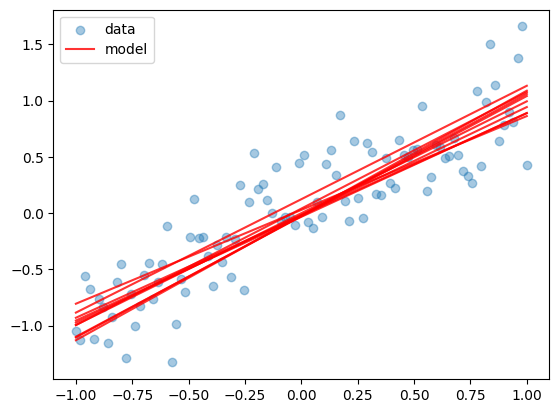

In [30]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

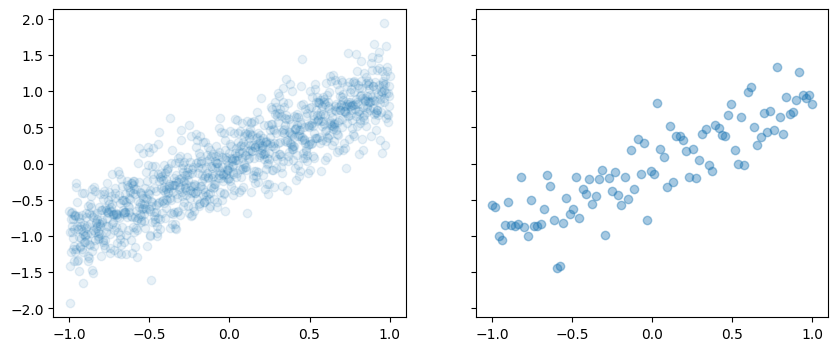

In [34]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)

In [32]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

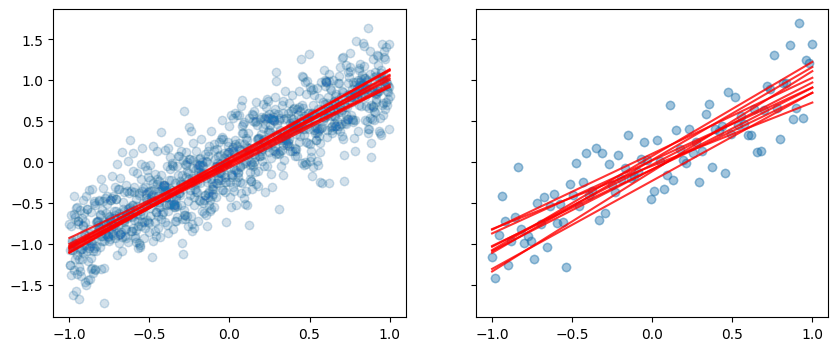

In [33]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_3 (Dense  (None, 8)                 152       
 Variational)                                                    
                                                                 
 dense_variational_4 (Dense  (None, 2)                 189       
 Variational)                                                    
                                                                 
 independent_normal_1 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 341 (1.33 KB)
Trainable params: 341 (1.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


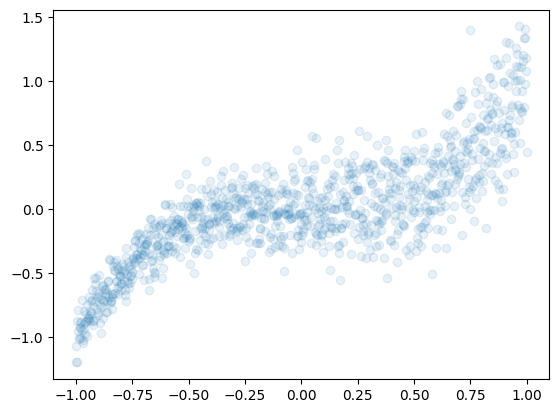

In [35]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)

# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

In [38]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 533us/step - loss: 0.0172


0.017150238156318665

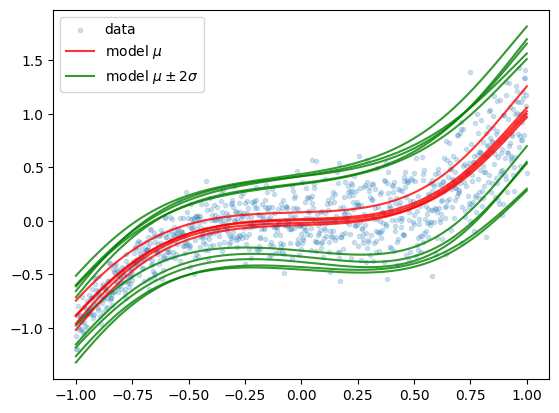

In [39]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

### Reparameterization layers

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, MaxPool2D

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3],
                                         activation='relu',
                                         input_shape=(28, 28, 1),
                                         kernel_posterior_fn=tfpl.default_mean_field_nromal_fn(),
                                         kernel_posterior_tensor_fn=tfd.Distribution.sample,
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
                                         bias_posterior_tensor_fn=tfd.Distribution.sample,
                                         bias_prior_fn=None,
                                         kernel_divergence_fn=(lambda q, p, _: tfd.kl_divergence(q, p) / N)),

    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)
])

/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_62509/438848399.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  integer = int(data_integer[row])


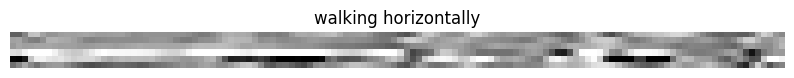

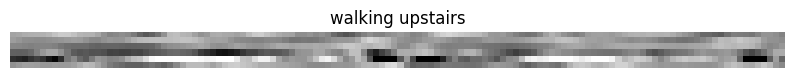

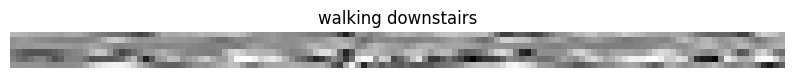

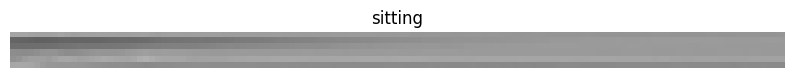

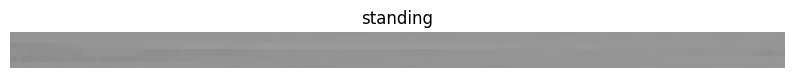

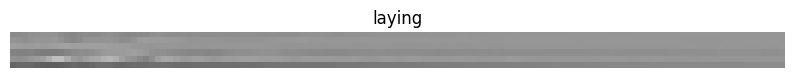

In [5]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = './HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)


def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

In [6]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 113, 8)            776       
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 8)              0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 6)                 342       
                                                                 
Total params: 1118 (4.37 KB)
Trainable params: 1118 (4.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(
        input_shape=(128, 6), filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), 
        kernel_divergence_fn=(divergence_fn),
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), 
        bias_divergence_fn=divergence_fn),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), 
        kernel_divergence_fn=(divergence_fn),
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False), 
        bias_divergence_fn=divergence_fn
    ),
    tfpl.OneHotCategorical(6) 
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_reparameterization   (None, 113, 8)            1552      
 (Conv1DReparameterization)                                      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 8)              0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 56)                0         
                                                                 
 dense_reparameterization (  (None, 6)                 684       
 DenseReparameterization)                                        
                                                                 
 one_hot_categorical (OneHo  ((None, 6),               0         
 tCategorical)                (None, 6))              

/Users/randy/.conda/envs/numpy_m1_build/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/randy/.conda/envs/numpy_m1_build/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [8]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [9]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [10]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

93/93 [==============================] - 0s 701us/step - loss: 0.8924 - accuracy: 0.7095


[0.8924223780632019, 0.7095351219177246]

In [11]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


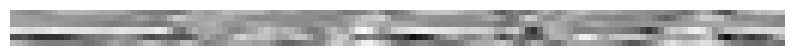

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_62509/1279574136.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


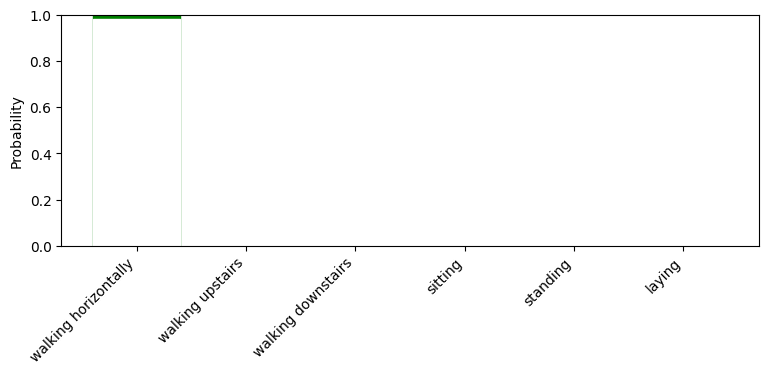

In [12]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


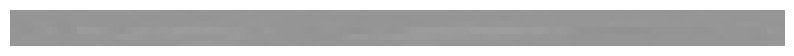

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_62509/1279574136.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


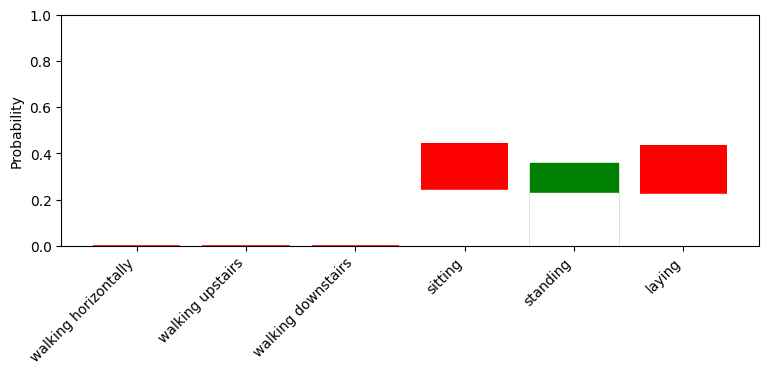

In [13]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


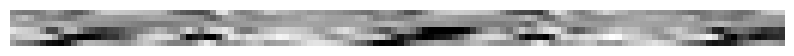

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


/var/folders/tk/jsn6b4hd0s71zfyq00x6ldcc0000gn/T/ipykernel_62509/1279574136.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


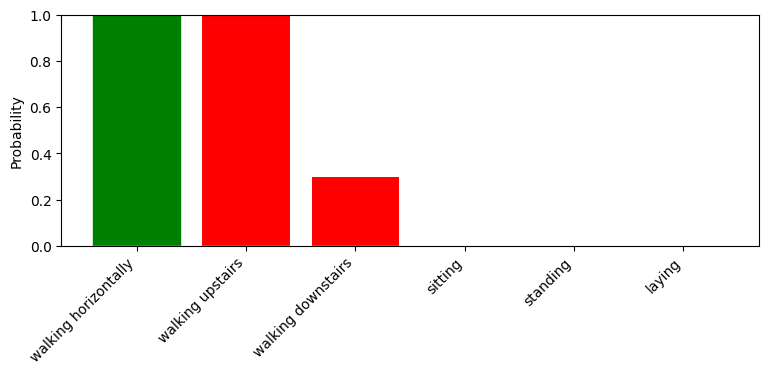

In [14]:
analyse_model_predictions(image_num=1137)

- aleatoric uncertainty: finding non-deterministic distribution of the data
- epicstemic uncertainty: comes from training data, event the distribution can be uncertain